# 1. Modules

## 1.1. Load basics

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

## 1.2. Load library modules

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

import skimage

from magrec.misc.plot import plot_n_components
from magrec.transformation.Bxyz2Jxy import Bxyz2Jxy
from magrec.transformation.Jxy2Bxyz import Jxy2Bxyz
from magrec.transformation.Bsensor2Jxy import Bsensor2Jxy
from magrec.transformation.MagneticFields import MagneticFields 

from magrec.misc.data import Data
from magrec import __datapath__


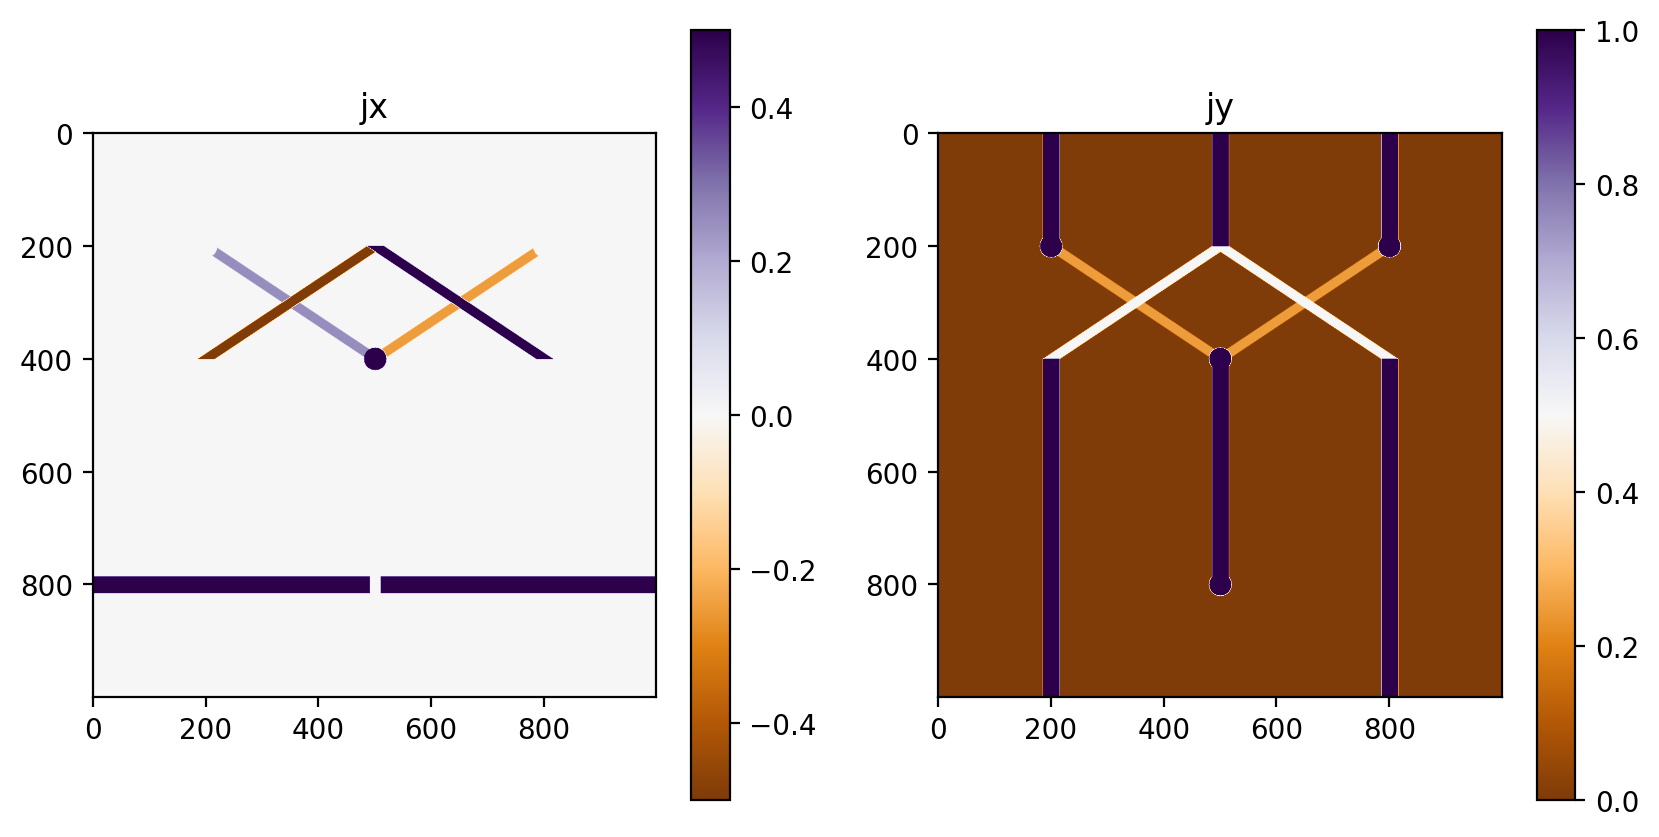

In [124]:
# Simulate a simple current wire pattern

jx = np.zeros((1000, 1000))
jy = np.zeros((1000, 1000))


# Add a circle pattern to the image
def circle(image, xp, yp,  r,  curr=1):
    x = np.arange(image.shape[0])[:, None]
    y = np.arange(image.shape[1])[None, :]
    # Create a mask for the circle
    mask = (x - xp) ** 2 + (y - yp) ** 2 <= r ** 2
    image[mask] = curr
    return image

def y_line(image, x1, y1, x2, y2, width=1, curr=1):
    # Create a boolean mask for the line
    mask = np.zeros(image.shape, dtype=bool)
    # Create a mask for the line
    for i in range(width):
        rr, cc = skimage.draw.line(x1, 
                                   y1 - i + width//2, 
                                   x2, 
                                   y2 - i+ width//2)
        mask[rr, cc] = True
    image[mask] = curr
    return image

def x_line(image, x1, y1, x2, y2, width=1, curr=1):
    # Create a boolean mask for the line
    mask = np.zeros(image.shape, dtype=bool)
    # Create a mask for the line
    for i in range(width):
        rr, cc = skimage.draw.line(x1 - i + width//2, 
                                   y1, 
                                   x2 - i+ width//2, 
                                   y2 )
        mask[rr, cc] = True
    image[mask] = curr
    return image

jy = y_line(jy, 0, 200, 200, 200, width=30)
jy = y_line(jy, 0, 800, 200, 800, width=30)
# Layer 2
jy = y_line(jy, 200, 200, 400, 500, width=30, curr=0.25)
jy = y_line(jy, 200, 800, 400, 500, width=30, curr=0.25)
# Layer 1
jy = y_line(jy, 200, 500, 400, 200, width=30, curr=0.5)
jy = y_line(jy, 200, 500, 400, 800, width=30, curr=0.5)
jy = y_line(jy, 0, 500, 200, 500, width=30)
jy = y_line(jy, 400, 800, 999, 800, width=30)
jy = y_line(jy, 400, 200, 999, 200, width=30)

jy = circle(jy, 200, 200, 20)
jy = circle(jy, 200, 800, 20)
# jy = circle(jy, 200, 500, 20)
jy = circle(jy, 400, 500, 20)
jy = y_line(jy, 410, 500, 800, 500, width=30)
jy = circle(jy, 800, 500, 20)

# jx data
jx = y_line(jx, 200, 200, 400, 500, width=30, curr=0.25)
jx = y_line(jx, 200, 800, 400, 500, width=30, curr=-0.25)
jx = y_line(jx, 200, 500, 400, 200, width=30, curr=-0.5)
jx = y_line(jx, 200, 500, 400, 800, width=30, curr=0.5)

jx = circle(jx, 200, 200, 20, curr=0)
jx = circle(jx, 200, 800, 20, curr=0)
jx = circle(jx, 400, 500, 20, curr=0.5)
jx = x_line(jx, 400, 510, 400, 500, width=30, curr=0.5)

jx = x_line(jx, 800, 490, 800, 0, width=30, curr=0.5)
jx = x_line(jx, 800, 510, 800, 999, width=30, curr=0.5)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('jx')
plt.imshow(jx, cmap='PuOr')
plt.colorbar()
plt.subplot(122)
plt.title('jy')
plt.imshow(jy, cmap='PuOr')
plt.colorbar()


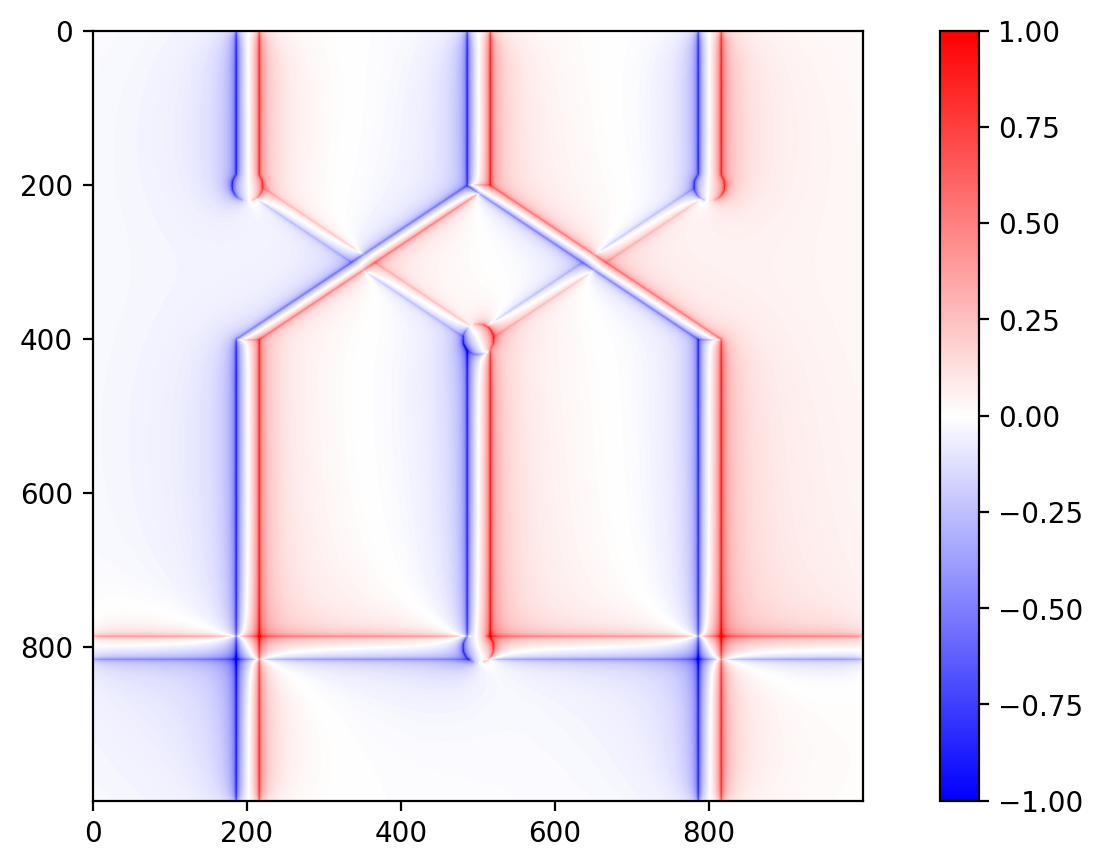

In [125]:
# Transform the image to a magnetic field

dataset = Data()
dx = 0.4
dy = 0.4
height = 0.1
thickness = 0

dataset.load_data(
       [jy,jx], 
       dx, 
       dy, 
       height, 
       0, 
       0, 
       thickness)


# Create the transformation object
B2J = Jxy2Bxyz(dataset)
# Transform the image to a magnetic field
B = B2J.transform()
# Plot the magnetic field
plt.figure(figsize=(10, 5))
plt.imshow(B[2]*1e6, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()